In [1]:
import os
os.chdir('..')

In [40]:
pwd

'/mnt/md1/user_victor/automatic_melody_harmonization'

In [3]:
from tonal import pianoroll2number, joint_prob2pianoroll96
from tonal import tonal_centroid, chord482note, chord962note, note2number
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pickle
# from model.CVAE_lstm_decoder import CVAE
# from model.CTDCVAE_lstm_decoder_conv_prenet import CVAE
from decode import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# melody_framewise = np.load('./data/melody_data.npy')
# chord_groundtruth_idx = np.load('./data/chord_groundtruth.npy')

# melody = np.load('./data/melody_baseline.npy')
chord_seqs = np.load('./data/number_96.npy')
# chord_onehot = np.load('./data/onehot_96.npy')
length = np.load('./data/length.npy')

# f = open('./data/tempos', 'rb')
# tempos = pickle.load(f)
# f.close()
# f = open('./data/downbeats', 'rb')
# downbeats = pickle.load(f)
# f.close()

In [49]:
## Markov chain
class markov_chain(): 
    def __init__(self,chord_seqs,states = [x for x in range(96)]):
        
        self.chord_seqs = chord_seqs
        self.states = states
        self.num_state = len(states) #number of states
        self.M = [[0]*self.num_state for _ in range(self.num_state)]
    
    # Input one seq
    def transition_probability(self,seq):
#         M = [[0]*self.num_state for _ in range(self.num_state)]
        
        # Convert seq to index seq
        index_seq = [self.states.index(i) for i in seq]
       
        for (i,j) in zip(index_seq,index_seq[1:]):
            self.M[i][j] += 1

        #now convert to probabilities:
        for row in self.M:
            s = sum(row)
            if s > 0:
                row[:] = [f/s for f in row]
    
    # Input one seq
    def create_transition_matrix_by_one_seq(self,seq):
        self.transition_probability(seq)
        return np.array(self.M)
    
    # Input seqs
    def create_transition_matrix_by_many_seqs(self):
        for seq in self.chord_seqs:
            self.transition_probability(seq)
        return np.array(self.M)
    
    # Input one seq
    def calculate_surprisingness(self,seq,t,TM):
        
        current = seq[t]
        i_ = self.states.index(current)

        previous = seq[t - 1]
        j_ = self.states.index(previous)

        if TM[i_][j_] == 0:
            surprisingness = -np.log(TM[i_][j_] + 1e-4)
        else:
            surprisingness = -np.log(TM[i_][j_])
            
        return surprisingness
    
    def create_surprisingness_seqs(self,all_data=False):
    
        surprisingness_seqs = []
        n = len(self.chord_seqs)
        states = [x for x in range(96)]
        
        if all_data:
            TM = self.create_transition_matrix_by_many_seqs().transpose()
            
        for i in tqdm(range(n)):
            seq = self.chord_seqs[i]
            N = len(seq)
            T = range(1,N)
            surprisingness_seq = [0]

            if all_data:
                for t in T:
                    surprisingness = self.calculate_surprisingness(seq,t,TM)
                    surprisingness_seq.append(surprisingness)
                
            else:
                for t in T:
                    TM = self.create_transition_matrix_by_one_seq(seq[:t]).transpose()
                    self.M = [[0]*self.num_state for _ in range(self.num_state)]
                    surprisingness = self.calculate_surprisingness(seq,t,TM)
                    surprisingness_seq.append(surprisingness)
                   
            surprisingness_seqs.append(surprisingness_seq)

        surprisingness_seqs = np.array(surprisingness_seqs)
        surprisingness_seqs = np.expand_dims(surprisingness_seqs,axis=-1)

        return surprisingness_seqs, TM

In [72]:
## Print data 
surprisingness_seqs, TM = markov_chain(chord_seqs).create_surprisingness_seqs(all_data = True)

100%|██████████| 17430/17430 [00:53<00:00, 324.95it/s]


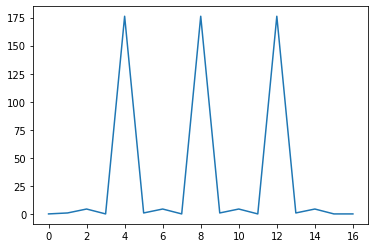

In [73]:
i = 0
l = length[i]
s = surprisingness_seqs[i].squeeze()
fig, ax = plt.subplots()
ax.plot(s[:l])

In [26]:
surprisingness_seqs = np.load('./data/surprisingness.npy')

In [116]:
surprisingness_seqs.shape

(17430, 272, 1)

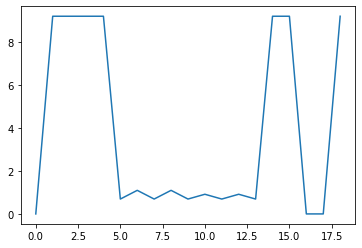

In [44]:
l = length[i]
s = surprisingness_seqs[i]
fig, ax = plt.subplots()
ax.plot(s[:l])

In [33]:
## Create Markov Chain for the whole data
seq = chord_seqs[i]
states = [x for x in range(96)]
transition_matrix(seq,states).create()
   
  

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [55]:
TM

array([[9.99983136e-01, 1.01443500e-05, 2.54629630e-01, ...,
        2.05555556e-01, 7.41767215e-02, 1.04166748e-04],
       [2.89193030e-46, 6.23823421e-01, 0.00000000e+00, ...,
        4.62962964e-06, 0.00000000e+00, 3.68019755e-13],
       [0.00000000e+00, 0.00000000e+00, 5.92592593e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.58651391e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.37620621e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.59732487e-03]])

In [66]:
TM

array([[9.99983136e-01, 1.01443500e-05, 2.54629630e-01, ...,
        2.05555556e-01, 7.41767215e-02, 1.04166748e-04],
       [2.89193030e-46, 6.23823421e-01, 0.00000000e+00, ...,
        4.62962964e-06, 0.00000000e+00, 3.68019755e-13],
       [0.00000000e+00, 0.00000000e+00, 5.92592593e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.58651391e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.37620621e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.59732487e-03]])

In [89]:
i = 20
surprisingness_seqs_ = []
# n = len(chord_seqs)
n = len(chord_seqs[0])
states = [x for x in range(96)]

# for i in tqdm(range(n)):

seq = chord_seqs[i]
N = len(seq)
T = range(1,N)
surprisingness_seq = [0]

for t in T:
    
    current = seq[t]
    i_ = states.index(current)

    previous = seq[t - 1]
    j_ = states.index(previous)

    if TM[i_][j_] == 0:
            surprisingness = -np.log(TM[i_][j_] + 1e-4)
    else:
        surprisingness = -np.log(TM[i_][j_])
    surprisingness_seq.append(surprisingness)

surprisingness_seqs_.append(surprisingness_seq)
surprisingness_seqs_ = np.array(surprisingness_seqs_)

In [81]:
surprisingness_seqs_.shape

(1, 272)

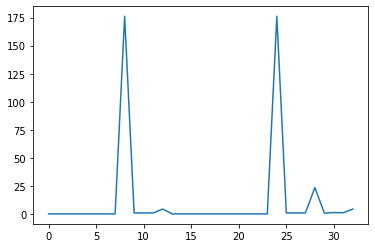

In [90]:
l = length[i]
s = surprisingness_seqs_[0]
fig, ax = plt.subplots()
ax.plot(s[:l])

In [71]:
i = 1
l = length[i]
s = surprisingness_seqs[i]
fig, ax = plt.subplots()
ax.plot(s[:l])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
TM